<a href="https://colab.research.google.com/github/jglombitza/tutorial_nn_airshowers/blob/main/fully_connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air-shower reconstruction using a fully-connected network
## Cosmic-ray observatory
In this example we will train a neural network to reconstruct air-shower properties measured by a hyptothetic cosmic-ray observatory located at a high of 1400 m. The observatory features a cartesian array of 14 x 14 particle detectors with a distance of 750m. 
Thus, the data contains the simulated detector response from secondary particles of the cosmic-ray induced air shower that interact with the ground-based observatory.  
Each particle detector measures two quantities, which are stored in the form of a cartesian image (2D array) corresponding to the station position coordinates:
- arrival time `T`: arrival time of the first particles
- signal `S`: integrated signal

In this task we are interested to reconstruct the Energy in EeV (Exaelectronvolt = $10^{18} eV$) using the measured particle footprint and a fully connected network


Reconstruct the properties of the arriving cosmic rays by analyzing their
air showers:

# Preparation:
Use a GPU for this task.
Therefore, click:
*Edit* -> *Notebook settings* -> *select GPU* as *Hardware accelerator*

# Reference
The tutorial is inspired by the simulation and the studay proposed in https://doi.org/10.1016/j.astropartphys.2017.10.006.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

layers = keras.layers

print("keras", keras.__version__)
print("tf", tf.__version__)

keras 2.6.0
tf 2.6.0


### Download data

In [2]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1nQDddS36y4AcJ87ocoMjyx46HGueiU6k"
output = 'airshowers.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=False)

f = np.load(output)

### Input 1: Arrival times
Our first input are the arrival times of the first shower particles, measured at the various stations.
We normalize the arrival times with respect to the mean and the standard deviation of the arrival time distribution.
Each input has the shape of 14 x 14, as each station measures an individual arrival time.

In [3]:
# time map
T = f['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

print(T.shape)

(200000, 9, 9)


#### Plot four example arrival time maps
To visualize a map of arrival times we can plot a random example event.
Here, the dark blue indicates an early trigger and a bright yellow a late trigger. With this information one can directly get an impression of the shower axis (arrival direction) of the arriving particle shower.

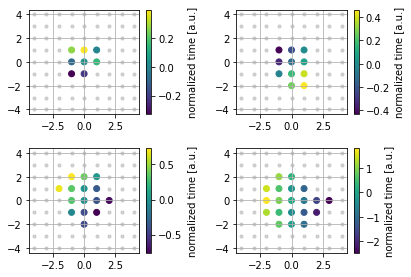

In [4]:
nsamples=len(T)
random_samples = np.random.choice(nsamples, 4)

def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=T[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], 
                          cmap="viridis", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized time [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Input 2: Measured signals
In the following we inspect the measured signals of the detectors.
Again for each event we have 14 x 14 measurements (a few are zero as we measure no signals).
We process the signal using a logarithmic re-scaling.

In [5]:
# signal map
S = f['signal']
S = np.log10(1 + S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

print(S.shape)

(200000, 9, 9)


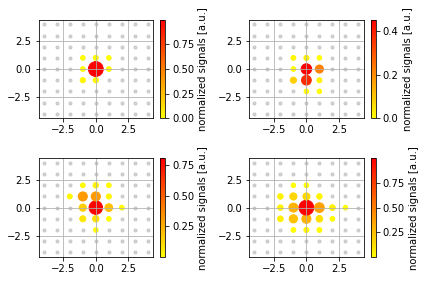

In [6]:
for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=S[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 200 * footprint[mask] + 20
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], s=marker_size,
                          cmap="autumn_r", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized signals [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

Combine inputs

In [7]:
X = np.stack([T, S], axis=-1)

### Labels
Now, we can prepare the targets of our neural network training.

In [8]:
axis = f['showeraxis']

In [9]:
core = f['showercore'][:, 0:2]
core /= 750

In [10]:
# energy - log10(E/eV) in range [18.5, 20]
energy = 10**(f['logE'] - 18)
print(energy)

[73.27273355 18.74237273 12.97710983 ...  5.16984186  8.52783593
 13.88057182]


We further split the data into one large training set and a smaller test set.
This test set is used for the final evaluation of the model and only used once to ensure an unbiased performance measure.

In [11]:
X_train, X_test = np.split(X, [-20000])
energy_train, energy_test = np.split(energy, [-20000])

## Define Model
## Task 
In the following we will set up a neural network to reconstruct the energy of the particle shower.



---
Feel free to modify the model.
For example:
*   Change the number of nodes (but remember that the number of weights scales with n x n, also the final layer has to have only one node as we are reconstruction the energy, which is a scalar.)
*   Change the activation function, e.g., use `relu, tanh, sigmoid, softplus, elu, ` (take care to not use an activation for the final layer!)
*   Add new layers.
* Increase the Dropout fraction or place Dropout in between several layers if you observe overtraining (validation loss increases).
---



In [12]:
model = keras.models.Sequential(name="energy_regression_NN")

model.add(layers.Flatten(input_shape=X_train.shape[1:]))  # this layer re-arranges the 2D image to a vector, leave it as it is
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

Now we can have a deeper look at our designed model and inspect the number of adaptive parameters by printing the model summary.

In [13]:
print(model.summary())

Model: "energy_regression_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 162)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               16300     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)      

### Compile
We now compile the model to prepare it for the traning.
During the `compile` step we set a loss/objective function (`mean_squared_error`, as energy reconstruction is a regression task) and set an optimizer. In this case we use the Adam optimizer with a learning rate of 0.001.

To monitor the resolution and the biase of the model, we add them as a metric.

In [14]:
def resolution(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return tf.sqrt(var)


def bias(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return mean

In [15]:
model.compile(
    loss='mean_squared_error',
    metrics=[bias, resolution],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3))

### Training
Now we can run the training for 40 `epochs` (40-fold iteration over the dataset) using our traning data `X_train` and our energy labels `energy_train`.
For each iteration (calculating of the gradients, updating of the model parameters) we use 128 samples (`batch_size`).

We furhtermore can set the fraction of data (initally set to `0.1`), which should be used for validation to monitor over trianing.



In [16]:
fit = model.fit(
    X_train,
    energy_train,
    batch_size=128,
    epochs=40,
    verbose=2,
    validation_split=0.1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=10, verbose=1),
               keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Epoch 1/40
1266/1266 - 5s - loss: 100.5154 - bias: 0.6186 - resolution: 7.8746 - val_loss: 14.1326 - val_bias: 0.0454 - val_resolution: 3.7190
Epoch 2/40
1266/1266 - 4s - loss: 28.9268 - bias: 0.2859 - resolution: 5.2170 - val_loss: 14.1315 - val_bias: 1.0694 - val_resolution: 3.5408
Epoch 3/40
1266/1266 - 4s - loss: 25.1548 - bias: 0.2706 - resolution: 4.8977 - val_loss: 11.3791 - val_bias: 0.3660 - val_resolution: 3.3113
Epoch 4/40
1266/1266 - 4s - loss: 24.1242 - bias: 0.2691 - resolution: 4.7741 - val_loss: 9.2041 - val_bias: 0.4482 - val_resolution: 2.9611
Epoch 5/40
1266/1266 - 4s - loss: 21.9555 - bias: 0.2567 - resolution: 4.5630 - val_loss: 13.1265 - val_bias: -1.3529e+00 - val_resolution: 3.3196
Epoch 6/40
1266/1266 - 4s - loss: 21.9690 - bias: 0.2588 - resolution: 4.5585 - val_loss: 10.7121 - val_bias: -6.9280e-01 - val_resolution: 3.1600
Epoch 7/40
1266/1266 - 4s - loss: 20.8802 - bias: 0.2503 - resolution: 4.4420 - val_loss: 7.0427 - val_bias: 0.4103 - val_resolution: 2.58

### Plot training curves

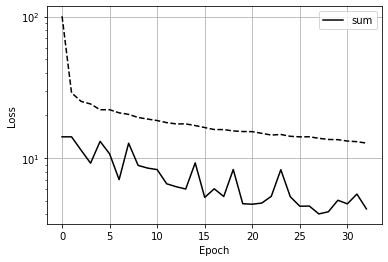

In [17]:
fig, ax = plt.subplots(1)
n = np.arange(len(fit.history['loss']))


ax.plot(n, fit.history['loss'], ls='--', c='k')
ax.plot(n, fit.history['val_loss'], label='sum', c='k')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.semilogy()
ax.grid()
plt.show()

#### Unweighted losses

## Study performance of the DNN

In [18]:
energy_pred = model.predict(X_test, batch_size=128, verbose=1)[:,0]


157/157 [==============================] - 0s 1ms/step


### Reconstruction performance of the shower energy

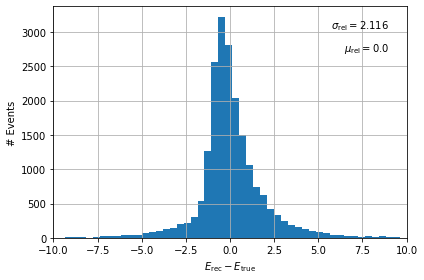

In [20]:
diff = energy_pred - energy_test
resolution = np.std(diff)
plt.figure()
plt.hist(diff, bins=100)
plt.xlabel('$E_\mathrm{rec} - E_\mathrm{true}$')
plt.ylabel('# Events')
plt.text(0.95, 0.95, '$\sigma_\mathrm{rel} = %.3f$' % resolution, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.85, '$\mu_\mathrm{rel} = %.1f$' % diff.mean(), ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.xlim(-10, 10)
plt.tight_layout()

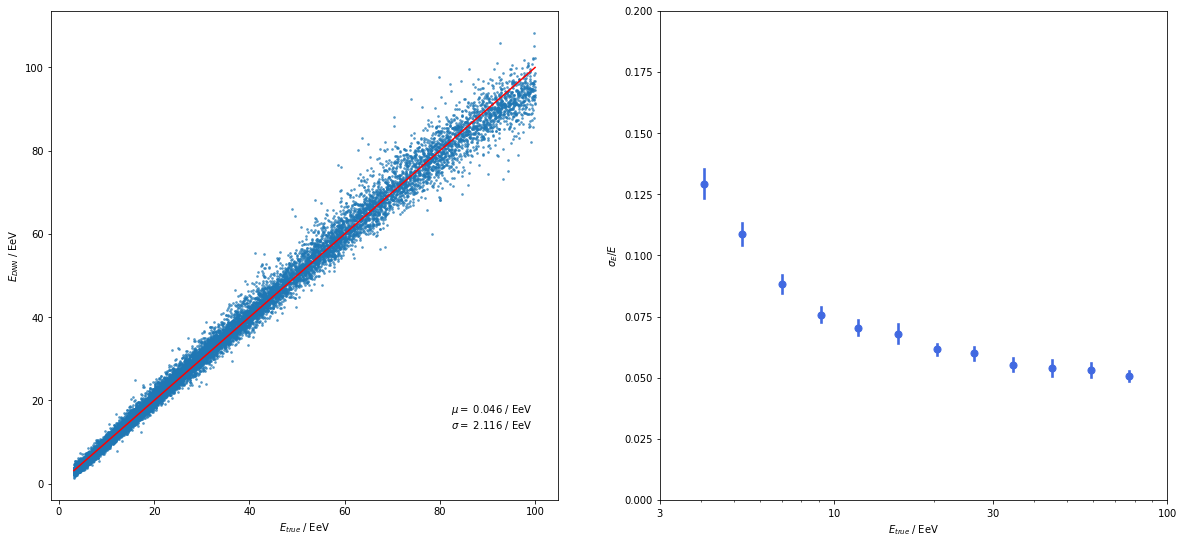

In [21]:
x = [3, 10, 30, 100]
labels = ["$3$", "$10$", "$30$", "$100$"]

diff = energy_pred - energy_test

# Embedding plot
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
axes[0].scatter(energy_test, energy_pred, s=3, alpha=0.60)
axes[0].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[0].set_ylabel(r"$E_{DNN}\;/\;\mathrm{EeV}$")

stat_box = r"$\mu = $ %.3f" % np.mean(diff) + " / EeV" + "\n" + "$\sigma = $ %.3f" % np.std(diff) + " / EeV"
axes[0].text(0.95, 0.2, stat_box, verticalalignment="top", horizontalalignment="right",
          transform=axes[0].transAxes, backgroundcolor="w")
axes[0].plot([np.min(energy_test), np.max(energy_test)],
             [np.min(energy_test), np.max(energy_test)], color="red")

sns.regplot(x=energy_test, y=diff / energy_test, x_estimator=np.std, x_bins=12,
            fit_reg=False, color="royalblue", ax=axes[1])
axes[1].tick_params(axis="both", which="major")
axes[1].set(xscale="log")
plt.xticks(x, labels)

axes[1].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[1].set_ylabel(r"$\sigma_{E}/E$")
axes[1].set_ylim(0,0.2)
plt.show()